# Proyecto 3 - Análisis Internacional de Tasas de Desempleo

## Aprendizaje Colaborativo Internacional en Línea

Esta tarea se encuentra en el marco de la aplicación del programa de Aprendizaje Colaborativo Internacional en Línea (COIL – siglas en inglés de “Collaborative Online International Learning”) de la Asociación de Universidades Confiadas a la Compañía de Jesús en América Latina (AUSJAL).

Dentro del trabajo se analiza la evolución de las tasas de desempleo en México, China y Colombia durante la última década usando datos reales obtenidos de un dataset global.

## Carga de bibliotecas

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

## Pregunta de investigación

¿Cómo ha evolucionado la tasa de desempleo total (ambos sexos, todos los grupos de edad) en los últimos 10 años en México, China y Colombia?

## Carga y preparación de datos

In [61]:
df = pd.read_csv('global_unemployment_data.csv')

# Filtramos por los países asignados
countries_of_interest = ['Mexico', 'China', 'Colombia']
df_filtered = df[df['country_name'].isin(countries_of_interest)].copy()

# Convertimos los años a numeric
year_columns = [str(year) for year in range(2014, 2025)]
for col in year_columns:
    df_filtered.loc[:, col] = pd.to_numeric(df_filtered[col], errors='coerce')

df_melted = pd.melt(
    df_filtered,
    id_vars=['country_name', 'sex', 'age_group', 'age_categories'],
    value_vars=[str(year) for year in range(2014, 2024)],
    var_name='year',
    value_name='unemployment_rate'
)
df_melted['year'] = pd.to_numeric(df_melted['year'])

print("Processed data sample:")
print(df_melted.head(10))


Processed data sample:
  country_name     sex age_group age_categories  year  unemployment_rate
0        China  Female     15-24          Youth  2014              9.397
1        China  Female       25+         Adults  2014              3.211
2        China  Female  Under 15       Children  2014              4.018
3        China    Male     15-24          Youth  2014             11.441
4        China    Male       25+         Adults  2014              4.167
5        China    Male  Under 15       Children  2014              5.123
6     Colombia  Female     15-24          Youth  2014             23.590
7     Colombia  Female       25+         Adults  2014              8.592
8     Colombia  Female  Under 15       Children  2014             11.304
9     Colombia    Male     15-24          Youth  2014             14.566


## Visualización por año y sexo

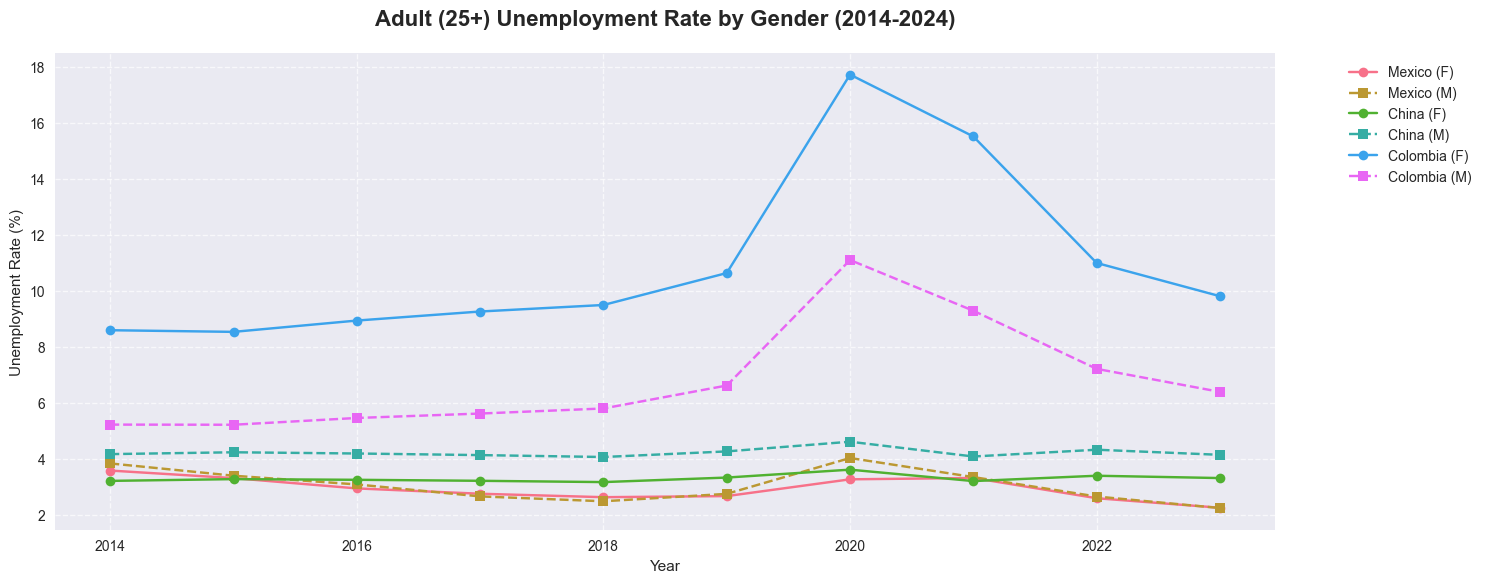

In [62]:
plt.figure(figsize=(15, 6))

df_adults = df_melted[
    (df_melted['age_group'] == '25+')
]

for country in countries_of_interest:
    country_data = df_adults[df_adults['country_name'] == country]
    female_data = country_data[country_data['sex'] == 'Female']
    plt.plot(female_data['year'], female_data['unemployment_rate'],
             marker='o', linestyle='-', label=f'{country} (F)')

    male_data = country_data[country_data['sex'] == 'Male']
    plt.plot(male_data['year'], male_data['unemployment_rate'],
             marker='s', linestyle='--', label=f'{country} (M)')

plt.title('Adult (25+) Unemployment Rate by Gender (2014-2024)',
          pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Visualización por grupo de edad por país

<Figure size 1500x800 with 0 Axes>

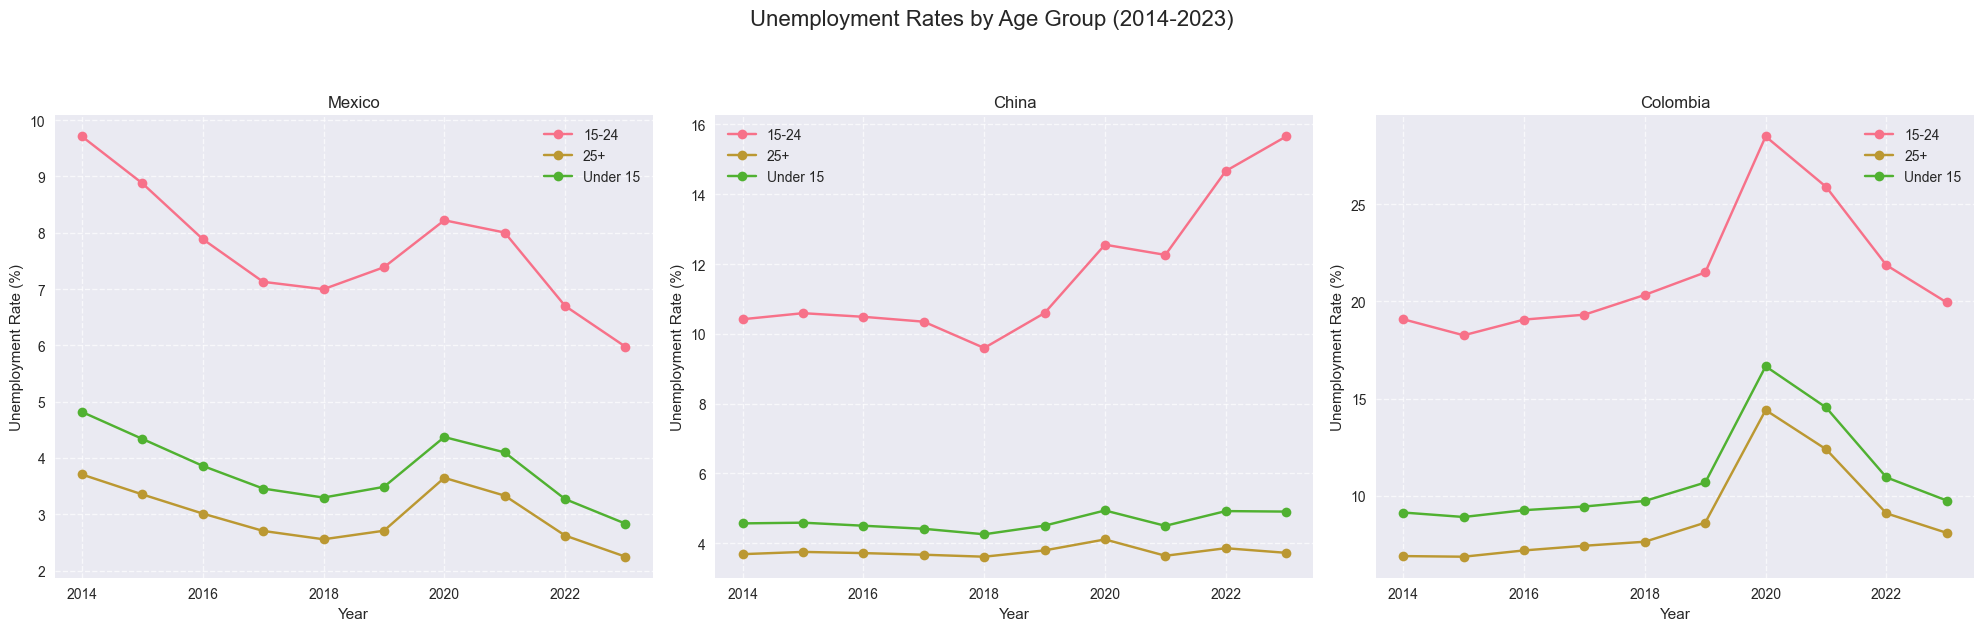

In [63]:
df_total = (
    df_melted.groupby(['country_name', 'age_group', 'year'], as_index=False)
    .agg({'unemployment_rate': 'mean'})
)
df_total['sex'] = 'Total'

df_melted_combined = pd.concat([df_melted, df_total], ignore_index=True)

plt.figure(figsize=(15, 8))

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Unemployment Rates by Age Group (2014-2023)', fontsize=16, y=1.05)

for idx, country in enumerate(countries_of_interest):
    country_data = df_melted_combined[df_melted_combined['country_name'] == country]

    for age_group in ['15-24', '25+', 'Under 15']:
        age_data = country_data[(country_data['age_group'] == age_group) & (country_data['sex'] == 'Total')]
        axes[idx].plot(age_data['year'], age_data['unemployment_rate'],
                      marker='o', label=age_group)

    axes[idx].set_title(country)
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Unemployment Rate (%)')
    axes[idx].grid(True, linestyle='--', alpha=0.7)
    axes[idx].legend()

plt.tight_layout()
plt.show()


## Análisis estadístico

In [64]:
def calculate_gender_gap(data):
    """
    Calculate unemployment rate gap between females and males.
    Returns the difference (female_rate - male_rate).
    """
    try:
        female_rate = data[data['sex'] == 'Female']['unemployment_rate'].mean()
        male_rate = data[data['sex'] == 'Male']['unemployment_rate'].mean()
        return female_rate - male_rate
    except Exception as e:
        print(f"Error calculating gender gap: {e}")
        return None

def calculate_youth_adult_ratio(data):
    """
    Calculate the ratio of youth (15-24) to adult (25+) unemployment rates.
    """
    try:
        youth_rate = data[data['age_group'] == '15-24']['unemployment_rate'].mean()
        adult_rate = data[data['age_group'] == '25+']['unemployment_rate'].mean()
        return youth_rate / adult_rate if adult_rate != 0 else np.nan
    except Exception as e:
        print(f"Error calculating youth/adult ratio: {e}")
        return None

def plot_gender_gap(gender_gaps_df):
    """
    Create and display gender gap visualization.
    """
    plt.figure(figsize=(12, 6))

    bars = plt.bar(gender_gaps_df['Country'],
                   gender_gaps_df['Gender Gap'],
                   color='skyblue')

    plt.title('Gender Gap in Unemployment (Female - Male) for Adults',
             pad=20,
             size=14)
    plt.xlabel('Country', size=12)
    plt.ylabel('Percentage Points', size=12)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.,
                height + (0.1 if height >= 0 else -0.1),
                f'{height:+.2f}%',
                ha='center',
                va='bottom' if height >= 0 else 'top')

    plt.tight_layout()
    plt.show()

def plot_youth_ratio(youth_ratios_df):
    """
    Create and display youth to adult ratio visualization.
    """
    plt.figure(figsize=(12, 6))

    bars = plt.bar(youth_ratios_df['Country'], 
                   youth_ratios_df['Youth/Adult Ratio'],
                   color='lightgreen')

    plt.title('Youth to Adult Unemployment Ratio', 
             pad=20, 
             size=14)
    plt.xlabel('Country', size=12)
    plt.ylabel('Ratio', size=12)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.,
                height + 0.1,
                f'{height:.2f}x',
                ha='center',
                va='bottom')

    plt.tight_layout()
    plt.show()

def analyze_unemployment_data(df_melted, df_melted_combined, countries_of_interest):
    """
    Analyze unemployment data and create separate visualizations.
    """
    gender_gaps = []
    youth_ratios = []

    for country in countries_of_interest:
        country_data = df_melted[
            (df_melted['country_name'] == country) &
            (df_melted['age_group'] == '25+')
        ]
        gap = calculate_gender_gap(country_data)

        if gap is not None:
            gender_gaps.append({
                'Country': country,
                'Gender Gap': round(gap, 2)
            })

        country_data_combined = df_melted_combined[
            (df_melted_combined['country_name'] == country) &
            (df_melted_combined['sex'] == 'Total')
        ]
        ratio = calculate_youth_adult_ratio(country_data_combined)

        if ratio is not None:
            youth_ratios.append({
                'Country': country,
                'Youth/Adult Ratio': round(ratio, 2)
            })

    gender_gaps_df = pd.DataFrame(gender_gaps)
    youth_ratios_df = pd.DataFrame(youth_ratios)

    plot_gender_gap(gender_gaps_df)
    plot_youth_ratio(youth_ratios_df)

    print("\nNumerical Results:")
    print("\nGender Gap in Unemployment (Female - Male) for Adults:")
    print(gender_gaps_df.to_string(index=False))
    print("\nYouth to Adult Unemployment Ratio:")
    print(youth_ratios_df.to_string(index=False))

    return gender_gaps_df, youth_ratios_df

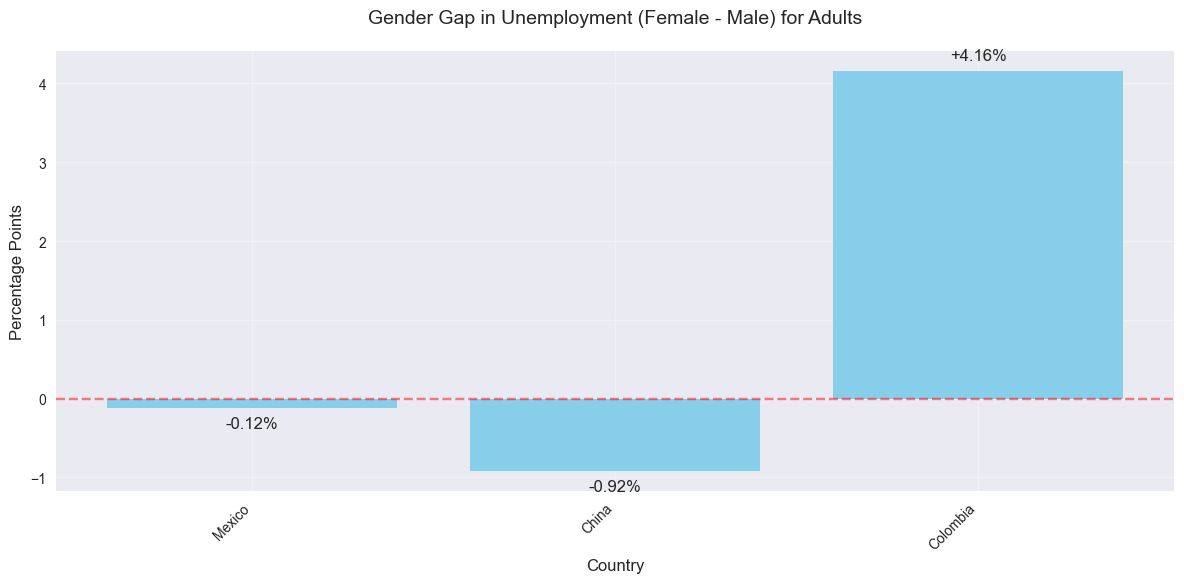

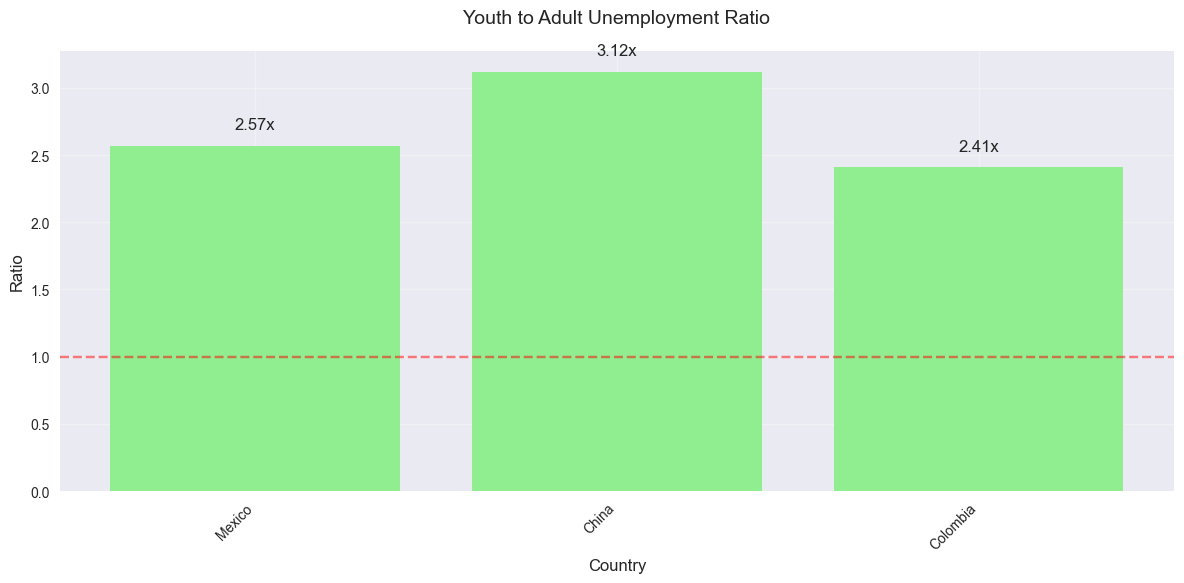


Numerical Results:

Gender Gap in Unemployment (Female - Male) for Adults:
 Country  Gender Gap
  Mexico       -0.12
   China       -0.92
Colombia        4.16

Youth to Adult Unemployment Ratio:
 Country  Youth/Adult Ratio
  Mexico               2.57
   China               3.12
Colombia               2.41


(    Country  Gender Gap
 0    Mexico       -0.12
 1     China       -0.92
 2  Colombia        4.16,
     Country  Youth/Adult Ratio
 0    Mexico               2.57
 1     China               3.12
 2  Colombia               2.41)

In [65]:
analyze_unemployment_data(df_melted, df_melted_combined, countries_of_interest)

### Conclusiones

1. Evolución y Brechas de Género:
   - México y China presentan una tendencia peculiar en la que las mujeres experimentan evolución en las tasas de desempleo más bajas que los hombres, con diferencias de -0.12 y -0.92 respectivamente. Sin embargo, este patrón no se mantiene de manera constante a lo largo de los años. En México, la tasa de desempleo femenina ha disminuido de forma constante en los últimos 10 años, pasando de 10.66% en 2014 a 6.89% en 2024, lo que refleja una mejora progresiva en la inclusión laboral femenina. En contraste, los hombres mexicanos también experimentan una tendencia de descenso, pero a un ritmo menos pronunciado.
   - Colombia muestra un patrón completamente diferente, con una brecha de género positiva persistente que alcanza un valor de 4.16 puntos. Las mujeres colombianas han enfrentado una tasa de desempleo mucho más alta que los hombres en todos los años observados, destacándose especialmente entre las jóvenes. En los últimos 10 años, la tasa de desempleo femenina en Colombia ha fluctuado entre 23.59% (2014) y 24.49% (2024) en el grupo juvenil, mientras que la de los hombres jóvenes disminuyó, aunque no tan drásticamente. Esto resalta desigualdades persistentes en el mercado laboral de Colombia que afectan particularmente a las mujeres.
   - Las diferencias de género entre los tres países sugieren que, mientras que en México y China se están reduciendo las brechas, en Colombia la discriminación laboral de género sigue siendo una barrera importante.

2. Desempleo por Grupos de Edad a lo Largo de los Años:
   - El desempleo juvenil (15-24 años) ha mostrado una tendencia a la baja en México y Colombia, aunque no de manera uniforme. En México, la tasa de desempleo juvenil ha disminuido significativamente, de 10.66% en 2014 a 6.89% en 2024, lo que indica una mejora sustancial en la inserción laboral de los jóvenes. En cambio, en Colombia, el desempleo juvenil ha fluctuado en niveles más altos, especialmente entre las mujeres, con un pequeño repunte en los últimos años.
   - China presenta una tasa de desempleo juvenil que ha experimentado un aumento en la última década, pasando de 9.39% en 2014 a 13.82% en 2024, lo que refleja una creciente dificultad para los jóvenes en el acceso al empleo. Esto resalta un desafío grave para el país, dado que la diferencia en desempleo juvenil/adulto es la más alta de los tres, con una ratio de 3.12.
   - Las tendencias de desempleo juvenil/adulto indican que, si bien los jóvenes siguen siendo el grupo más afectado, el desempleo juvenil está comenzando a disminuir en México y Colombia. Por el contrario, en China, el desempleo juvenil sigue siendo un tema crítico.

3. Evolución Específica por País:
   - China: A pesar de tener la brecha de género más baja (siendo las mujeres menos desempleadas que los hombres), el desempleo juvenil ha sido un reto creciente. La tasa juvenil ha mostrado un incremento constante desde 2014, lo que pone de manifiesto las dificultades que enfrentan los jóvenes chinos para ingresar al mercado laboral. Este aumento de 9.39% en 2014 a 13.82% en 2024 pone en evidencia que el mercado laboral chino tiene que adaptarse más a las demandas y necesidades de los jóvenes.
   - México: La evolución del desempleo en México ha sido positiva en general, con una disminución progresiva tanto en el desempleo juvenil como en el desempleo adulto. Aunque las mujeres han experimentado una ligera disminución en su tasa de desempleo, los hombres también han visto una mejora, lo que refleja un avance hacia una mayor estabilidad laboral. Sin embargo, la tasa de desempleo juvenil sigue siendo alta, aunque ha descendido de 8.76% en 2014 a 5.78% en 2024.
   - Colombia: En Colombia, las mujeres jóvenes enfrentan las tasas de desempleo más altas de los tres países, con un leve descenso en los últimos años, pero aún muy por encima de los niveles de México y China. En general, la tasa de desempleo ha mostrado una tendencia fluctuante, con los hombres experimentando una ligera mejora, mientras que las mujeres, especialmente en el grupo juvenil, siguen enfrentando tasas muy elevadas.

4. Reflexión Final:
   - México y China han logrado reducir las tasas de desempleo a lo largo de la última década, especialmente en el caso del desempleo juvenil en México. Sin embargo, China muestra una tendencia preocupante con el incremento del desempleo juvenil, lo que plantea desafíos para el futuro de este grupo. En Colombia, aunque la tasa de desempleo juvenil ha disminuido, las brechas de género y la discriminación laboral siguen siendo un problema grave. La tasa de desempleo femenina es especialmente alta, reflejando las desigualdades estructurales que persisten en el país.
   - En todos los países, los jóvenes siguen enfrentando mayores dificultades para ingresar al mercado laboral, y las mujeres, aunque han visto mejoras en algunos casos, todavía se enfrentan a obstáculos significativos, especialmente en Colombia, donde las disparidades de género son muy marcadas.